In [101]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=4, rc={"lines.markersize": 15})
plt.rc('hatch', color='white', linewidth=1)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": ["Linux Biolinum"]  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/materialization'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

In [102]:
result_folder = ROOT_RESULT_FOLDER + '/materialization/kaggle_home_credit'
result_file = result_folder + '/cloud-41/2019-10-02.csv'

In [103]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','budget', 'total_mat', 'total_size','run_time'
]
mat_map = {'simple':'SM','storage_aware':'SA'}
materialization_result = pd.read_csv(result_file, header=None, names=HEADERS)
materialization_result['mat_type'] = materialization_result['mat_type'].replace(mat_map)
materialization_result[['budget', 'total_mat', 'total_size']] = materialization_result[['budget', 'total_mat', 'total_size']] / (1024. * 1024.)

In [104]:
#materialization_result

In [105]:
def plot_execution_time(df, loc=''):
    cat = sns.catplot(
        data=df,
        x='budget',
        y='run_time',
        hue='mat_type',
        kind ='bar',
        ci=99,
        hue_order=['SM', 'SA'],
        palette={
            'SA': SYSTEM_COLOR,
            'SM': BASELINE_COLOR
        },
        legend=False)
    #top = df['run_time'].max()
    #cat.set_axis_labels('Execution Number', 'Run Time (s)')
    cat.set_xlabels('Budget (GB)', fontsize=32)
    cat.set_ylabels('Total Run Time (s)', fontsize=32)
    
    #cat.set(ylim=(0, top + 100))
    plt.tick_params(labelsize = 28, rotation=90)
    
    budgets = len(df.budget.unique())
    for i, bar in enumerate(cat.ax.patches):
        if i < budgets:
            h = '/'
        else:
            h = 'x'
        bar.set_edgecolor('lightgray')
        bar.set_hatch(h)
        
    lg = plt.legend(loc='upper center', fontsize=28, ncol = 2, columnspacing=-1, bbox_to_anchor=(0.48,1.15))
    lg.legendHandles[0].xy = (45,0)
    lg.legendHandles[1].xy = (45,0)
    lg.legendHandles[0]._width = 31
    lg.legendHandles[1]._width = 31


    cat.savefig(loc, bbox_inches ='tight')

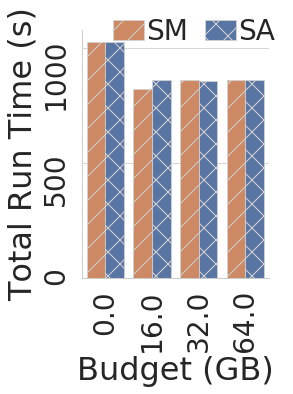

In [106]:
df = materialization_result.groupby(['exp_id','mat_type','budget'])['run_time'].sum().reset_index()
df = df[df.budget != 128]
plot_execution_time(df, output_directory+'/run-time.pgf')

In [266]:
def plot_sizes(df, loc=''):
    plt.figure(figsize=(5,4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='total_mat',
        hue='mat_type',
        style='mat_type',
        markers=["^", "o"],
        lw=3,
        hue_order=['SM', 'SA'],
        dashes=[(2, 2), (1, 0)],
        palette={
            'SA': SYSTEM_COLOR,
            'SM': BASELINE_COLOR
        },
        legend='brief')

    legend = plt.legend(loc='upper left', fontsize=38,handlelength=1.2,handletextpad=0.1,labelspacing = -.1,bbox_to_anchor=(-.08,1.25))
#     legend.legendHandles[0].xy = (1000,0)
#     legend.legendHandles[1].xy = (60,0)
#     legend.legendHandles[0]._width = 1
#     legend.legendHandles[1]._width = 31
    plot.set_ylim((0,140))
    legend.texts[0].set_text("")
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    plot.set_xlabel('Workload', fontsize=38)
    plot.set_ylabel('Size (GB)', fontsize=38)
    plt.tick_params(labelsize = 36)
    plot.set_xticklabels([1,2,3,4,5, 6])
    plot.set_xticks(range(1,6))
    plt.savefig(loc, bbox_inches ='tight')

In [267]:
execution_order = {'start_here_a_gentle_introduction':1,
                   'introduction_to_manual_feature_engineering':2,
                   'introduction_to_manual_feature_engineering_p2':3,
                   'fork_cridata_start_here_a_gentle_introduction':4,
                   'fork_taozhongxiao_start_here_a_gentle_introduction':5
                  }
df = materialization_result[['exp_id','workload','mat_type','budget','total_mat','total_size']]
df['workload_order'] = df['workload'].replace(execution_order)

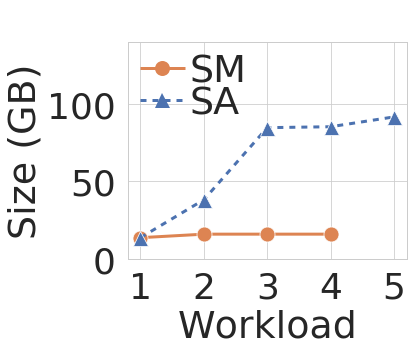

In [268]:
plot_sizes(df[df['budget'] == 16.0], output_directory+'/size-16.pgf')

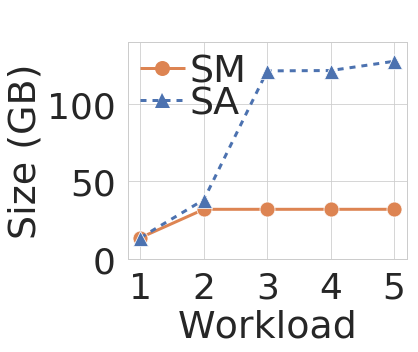

In [269]:
plot_sizes(df[df['budget'] == 32.0], output_directory+'/size-32.pgf')

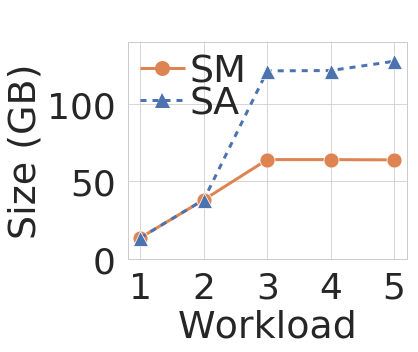

In [270]:
plot_sizes(df[df['budget'] == 64.0], output_directory+'/size-64.pgf')

In [271]:
# plot_sizes(df[df['budget'] == 128.0])